In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, Binarizer
#from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
os.chdir("../")


In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import torch
import matplotlib.pylab as plt

from sklearn.datasets import load_diabetes
from gpytorch.kernels import RBFKernel

from src.gp_models.VariationalGPRegression import VariationalGPRegression
from src.explanation_algorithms.BayesGPSHAP import BayesGPSHAP
from src.utils.visualisation.deterministic_values import summary_plot
from src.utils.visualisation.stochastic_values import local_explanation_plot, global_explanation_plot

In [3]:
data = pd.read_csv('race.csv')
data

Unnamed: 0  season  round   circuit_id  weather_warm  weather_cold   
0              14    1983      1  jacarepagua         False         False  \
1               5    1983      1  jacarepagua         False         False   
2               3    1983      1  jacarepagua         False         False   
3               0    1983      1  jacarepagua         False         False   
4               6    1983      1  jacarepagua         False         False   
...           ...     ...    ...          ...           ...           ...   
14789       15076    2021     11  hungaroring         False         False   
14790       15072    2021     11  hungaroring         False         False   
14791       15074    2021     11  hungaroring         False         False   
14792       15073    2021     11  hungaroring         False         False   
14793       15079    2021     11  hungaroring         False         False   

       weather_dry  weather_wet  weather_cloudy        driver  ... grid   
0             True        False           False  keke_rosberg  ...    1  \
1             True        False           False         prost  ...    2   
2             True        False           False        tambay  ...    3   
3             True        False           False        piquet  ...    4   
4             True        False           False       warwick  ...    5   
...            ...          ...             ...           ...  ...  ...   
14789        False         True           False     raikkonen  ...   13   
14790        False         True           False       tsunoda  ...   16   
14791        False         True           False       russell  ...   17   
14792        False         True           False        latifi  ...   18   
14793        False         True           False       mazepin  ...   19   

      podium  driver_points  driver_wins  driver_standings_pos   
0         15              0            0                     0  \
1          6              0            0                     0   
2          4              0            0                     0   
3          1              0            0                     0   
4          7              0            0                     0   
...      ...            ...          ...                   ...   
14789     10              1            0                    15   
14790      6             10            0                    14   
14791      8              0            0                    17   
14792      7              0            0                    19   
14793     14              0            0                    20   

       constructor_points  constructor_wins  constructor_standings_pos   
0                       0                 0                          0  \
1                       0                 0                          0   
2                       0                 0                          0   
3                       0                 0                          0   
4                       0                 0                          0   
...                   ...               ...                        ...   
14789                   2                 0                          8   
14790                  49                 0                          5   
14791                   0                 0                          9   
14792                   0                 0                          9   
14793                   0                 0                         10   

       qualifying_time  driver_age  
0                  0.0          34  
1                  0.2          28  
2                  0.3          33  
3                  0.6          30  
4                  0.7          28  
...                ...         ...  
14789              2.2          41  
14790              2.5          21  
14791              2.5          23  
14792              2.6          26  
14793              3.5          22  

[14794 rows x 22 columns]

# Data Preprocessing

In [4]:
data.drop("Unnamed: 0", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14794 entries, 0 to 14793
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   season                     14794 non-null  int64  
 1   round                      14794 non-null  int64  
 2   circuit_id                 14794 non-null  object 
 3   weather_warm               14794 non-null  bool   
 4   weather_cold               14794 non-null  bool   
 5   weather_dry                14794 non-null  bool   
 6   weather_wet                14794 non-null  bool   
 7   weather_cloudy             14794 non-null  bool   
 8   driver                     14794 non-null  object 
 9   nationality                14794 non-null  object 
 10  constructor                14794 non-null  object 
 11  grid                       14794 non-null  int64  
 12  podium                     14794 non-null  int64  
 13  driver_points              14794 non-null  int

In [5]:
data['weather_warm'] = data['weather_warm'].astype(int)
data['weather_cold'] = data['weather_cold'].astype(int)
data['weather_dry'] = data['weather_dry'].astype(int)
data['weather_wet'] = data['weather_wet'].astype(int)
data['weather_cloudy'] = data['weather_cloudy'].astype(int)
data

season  round   circuit_id  weather_warm  weather_cold  weather_dry   
0        1983      1  jacarepagua             0             0            1  \
1        1983      1  jacarepagua             0             0            1   
2        1983      1  jacarepagua             0             0            1   
3        1983      1  jacarepagua             0             0            1   
4        1983      1  jacarepagua             0             0            1   
...       ...    ...          ...           ...           ...          ...   
14789    2021     11  hungaroring             0             0            0   
14790    2021     11  hungaroring             0             0            0   
14791    2021     11  hungaroring             0             0            0   
14792    2021     11  hungaroring             0             0            0   
14793    2021     11  hungaroring             0             0            0   

       weather_wet  weather_cloudy        driver nationality  ... grid   
0                0               0  keke_rosberg     Finnish  ...    1  \
1                0               0         prost      French  ...    2   
2                0               0        tambay      French  ...    3   
3                0               0        piquet   Brazilian  ...    4   
4                0               0       warwick     British  ...    5   
...            ...             ...           ...         ...  ...  ...   
14789            1               0     raikkonen     Finnish  ...   13   
14790            1               0       tsunoda    Japanese  ...   16   
14791            1               0       russell     British  ...   17   
14792            1               0        latifi    Canadian  ...   18   
14793            1               0       mazepin     Russian  ...   19   

       podium  driver_points  driver_wins  driver_standings_pos   
0          15              0            0                     0  \
1           6              0            0                     0   
2           4              0            0                     0   
3           1              0            0                     0   
4           7              0            0                     0   
...       ...            ...          ...                   ...   
14789      10              1            0                    15   
14790       6             10            0                    14   
14791       8              0            0                    17   
14792       7              0            0                    19   
14793      14              0            0                    20   

       constructor_points  constructor_wins  constructor_standings_pos   
0                       0                 0                          0  \
1                       0                 0                          0   
2                       0                 0                          0   
3                       0                 0                          0   
4                       0                 0                          0   
...                   ...               ...                        ...   
14789                   2                 0                          8   
14790                  49                 0                          5   
14791                   0                 0                          9   
14792                   0                 0                          9   
14793                   0                 0                         10   

       qualifying_time  driver_age  
0                  0.0          34  
1                  0.2          28  
2                  0.3          33  
3                  0.6          30  
4                  0.7          28  
...                ...         ...  
14789              2.2          41  
14790              2.5          21  
14791              2.5          23  
14792              2.6          26  
14793              3.5          22  

[14794 rows x 21 columns]

In [77]:
F1_data = data.copy()
F1_data.drop([ 'round', 'circuit_id', 'driver', 'nationality', 'constructor'], axis=1, inplace=True)
F1_data

season  weather_warm  weather_cold  weather_dry  weather_wet   
0        1983             0             0            1            0  \
1        1983             0             0            1            0   
2        1983             0             0            1            0   
3        1983             0             0            1            0   
4        1983             0             0            1            0   
...       ...           ...           ...          ...          ...   
14789    2021             0             0            0            1   
14790    2021             0             0            0            1   
14791    2021             0             0            0            1   
14792    2021             0             0            0            1   
14793    2021             0             0            0            1   

       weather_cloudy  grid  podium  driver_points  driver_wins   
0                   0     1      15              0            0  \
1                   0     2       6              0            0   
2                   0     3       4              0            0   
3                   0     4       1              0            0   
4                   0     5       7              0            0   
...               ...   ...     ...            ...          ...   
14789               0    13      10              1            0   
14790               0    16       6             10            0   
14791               0    17       8              0            0   
14792               0    18       7              0            0   
14793               0    19      14              0            0   

       driver_standings_pos  constructor_points  constructor_wins   
0                         0                   0                 0  \
1                         0                   0                 0   
2                         0                   0                 0   
3                         0                   0                 0   
4                         0                   0                 0   
...                     ...                 ...               ...   
14789                    15                   2                 0   
14790                    14                  49                 0   
14791                    17                   0                 0   
14792                    19                   0                 0   
14793                    20                   0                 0   

       constructor_standings_pos  qualifying_time  driver_age  
0                              0              0.0          34  
1                              0              0.2          28  
2                              0              0.3          33  
3                              0              0.6          30  
4                              0              0.7          28  
...                          ...              ...         ...  
14789                          8              2.2          41  
14790                          5              2.5          21  
14791                          9              2.5          23  
14792                          9              2.6          26  
14793                         10              3.5          22  

[14794 rows x 16 columns]

In [78]:
data_2021 = F1_data.copy()
F1_data.drop([ 'constructor_wins'], axis=1, inplace=True)
F1_data

season  weather_warm  weather_cold  weather_dry  weather_wet   
0        1983             0             0            1            0  \
1        1983             0             0            1            0   
2        1983             0             0            1            0   
3        1983             0             0            1            0   
4        1983             0             0            1            0   
...       ...           ...           ...          ...          ...   
14789    2021             0             0            0            1   
14790    2021             0             0            0            1   
14791    2021             0             0            0            1   
14792    2021             0             0            0            1   
14793    2021             0             0            0            1   

       weather_cloudy  grid  podium  driver_points  driver_wins   
0                   0     1      15              0            0  \
1                   0     2       6              0            0   
2                   0     3       4              0            0   
3                   0     4       1              0            0   
4                   0     5       7              0            0   
...               ...   ...     ...            ...          ...   
14789               0    13      10              1            0   
14790               0    16       6             10            0   
14791               0    17       8              0            0   
14792               0    18       7              0            0   
14793               0    19      14              0            0   

       driver_standings_pos  constructor_points  constructor_standings_pos   
0                         0                   0                          0  \
1                         0                   0                          0   
2                         0                   0                          0   
3                         0                   0                          0   
4                         0                   0                          0   
...                     ...                 ...                        ...   
14789                    15                   2                          8   
14790                    14                  49                          5   
14791                    17                   0                          9   
14792                    19                   0                          9   
14793                    20                   0                         10   

       qualifying_time  driver_age  
0                  0.0          34  
1                  0.2          28  
2                  0.3          33  
3                  0.6          30  
4                  0.7          28  
...                ...         ...  
14789              2.2          41  
14790              2.5          21  
14791              2.5          23  
14792              2.6          26  
14793              3.5          22  

[14794 rows x 15 columns]

# Visualisation

<Axes: title={'center': 'Corrleation Heatmap of F1 data'}>

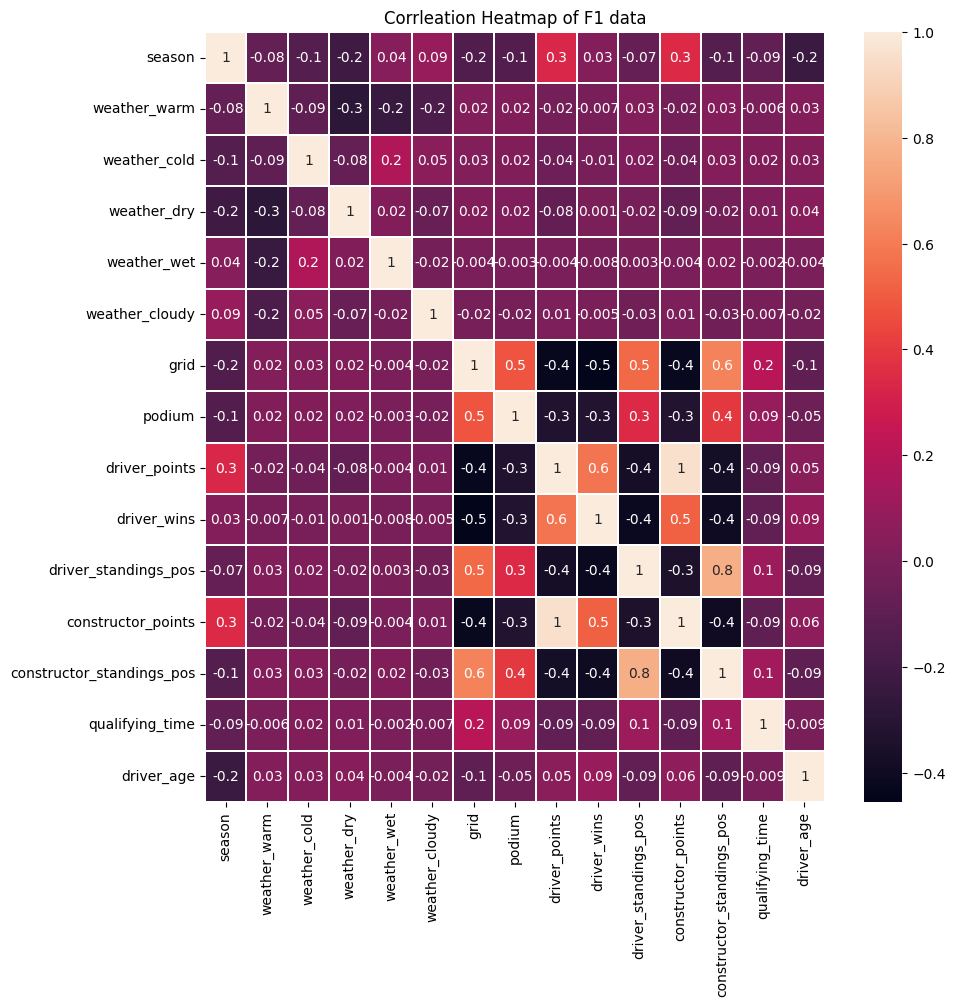

In [12]:
#heatmap
plt.title('Corrleation Heatmap of F1 data')
sns.heatmap(F1_data.corr(), annot=True, fmt='.1g', linewidths=.3)

In [10]:
#evaluation matrix
def get_clf_eval(y_test, pred=None):
    accuracy = accuracy_score(y_test, pred)
    rmse = mean_squared_error(y_test, pred,squared=False)
    r2 = r2_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    print('Accuracy: {0:.4f}, RMSE:{1:.4f},R2:{2:.4f}Precision: {3:.4f}, Recall {4:.4f}, F1: {5:.4f}'.format(accuracy,rmse,r2, precision, recall, f1))

In [11]:
#make the driver_win to binary value 0 and 1
binarizer = Binarizer(threshold=F1_data['driver_wins'].median())
F1_data['driver_wins'] = binarizer.fit_transform(np.array(F1_data['driver_wins']).reshape(-1, 1))
F1_data

season  weather_warm  weather_cold  weather_dry  weather_wet   
0        1983             0             0            1            0  \
1        1983             0             0            1            0   
2        1983             0             0            1            0   
3        1983             0             0            1            0   
4        1983             0             0            1            0   
...       ...           ...           ...          ...          ...   
14789    2021             0             0            0            1   
14790    2021             0             0            0            1   
14791    2021             0             0            0            1   
14792    2021             0             0            0            1   
14793    2021             0             0            0            1   

       weather_cloudy  grid  podium  driver_points  driver_wins   
0                   0     1      15              0            0  \
1                   0     2       6              0            0   
2                   0     3       4              0            0   
3                   0     4       1              0            0   
4                   0     5       7              0            0   
...               ...   ...     ...            ...          ...   
14789               0    13      10              1            0   
14790               0    16       6             10            0   
14791               0    17       8              0            0   
14792               0    18       7              0            0   
14793               0    19      14              0            0   

       driver_standings_pos  constructor_points  constructor_standings_pos   
0                         0                   0                          0  \
1                         0                   0                          0   
2                         0                   0                          0   
3                         0                   0                          0   
4                         0                   0                          0   
...                     ...                 ...                        ...   
14789                    15                   2                          8   
14790                    14                  49                          5   
14791                    17                   0                          9   
14792                    19                   0                          9   
14793                    20                   0                         10   

       qualifying_time  driver_age  
0                  0.0          34  
1                  0.2          28  
2                  0.3          33  
3                  0.6          30  
4                  0.7          28  
...                ...         ...  
14789              2.2          41  
14790              2.5          21  
14791              2.5          23  
14792              2.6          26  
14793              3.5          22  

[14794 rows x 15 columns]

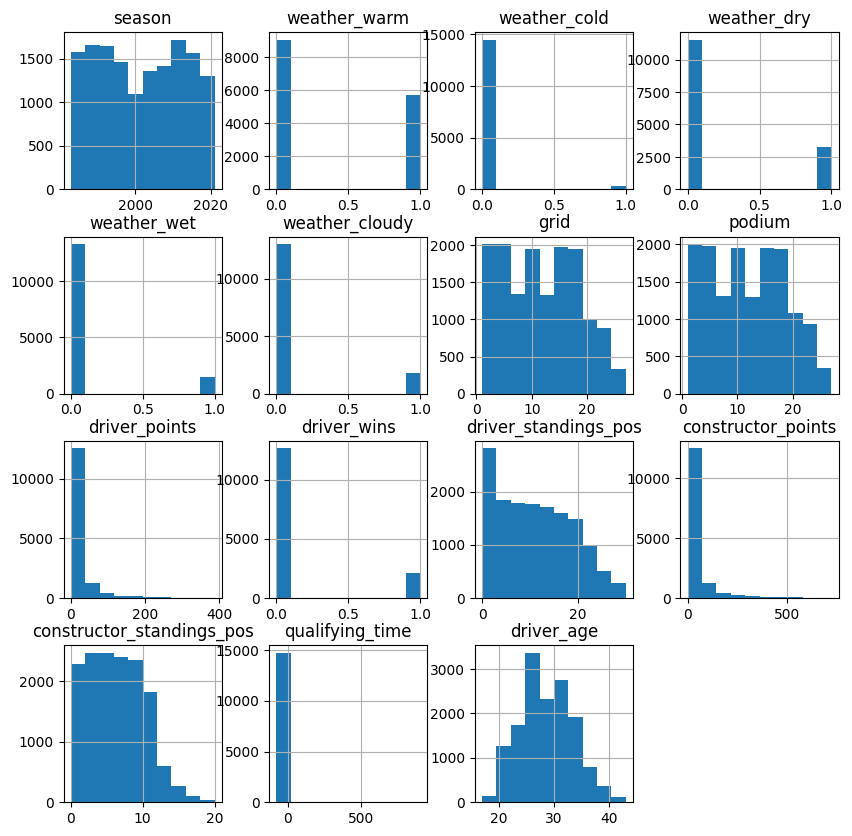

In [10]:
#histogram
f_hist = F1_data.hist(bins=10,figsize=(10,10))

In [13]:
# Set X, y for features and label
X = F1_data.drop('driver_wins', axis=1, inplace=False)
y = F1_data['driver_wins'].astype(int)
# Split datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (10355, 14)
Shape of X_test:  (4439, 14)
Shape of y_train:  (10355,)
Shape of y_test:  (4439,)


In [15]:
train_set, big_test_set = train_test_split(F1_data, test_size=0.7, random_state=42, stratify=F1_data['driver_wins'])
test_set, val_set = train_test_split(big_test_set, test_size=0.5, random_state=42, stratify=big_test_set['driver_wins'])
X_train = train_set.drop('driver_wins', axis=1, inplace=False)
y_train = train_set['driver_wins']
X_test = test_set.drop('driver_wins', axis=1, inplace=False)
y_test = test_set['driver_wins']
X_val = val_set.drop('driver_wins', axis=1, inplace=False)
y_val = val_set['driver_wins']
print(f'Shapes are\n X_train:{X_train.shape},y_train:{y_train.shape}, X_test:{X_test.shape},y_test:{y_test.shape},X_val:{X_val.shape},y_val:{y_val.shape}') 
print(f'Proportions are\n y_train:{np.mean(y_train)},y_test:{np.mean(y_test)},y_val:{np.mean(y_val)}')
 

Shapes are
 X_train:(4438, 14),y_train:(4438,), X_test:(5178, 14),y_test:(5178,),X_val:(5178, 14),y_val:(5178,)
Proportions are
 y_train:0.14465975664713834,y_test:0.14465044418694475,y_val:0.14465044418694475


In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# Building models

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_parameters = {'ccp_alpha':[0.01,0.1,0.2,0.5,0.9,1],
'max_depth':[1,5,10,20,30,40,50] }
dt_gridcv = GridSearchCV(dt_clf, dt_parameters, cv=5, scoring = 'neg_mean_squared_error')
dt_gridcv.fit(X_train, y_train)
print(f'Decision tree Best score is : {dt_gridcv.best_score_} of best parameter : {dt_gridcv.best_params_}') #Support vector machine classifier

dt_gridcv.best_estimator_.fit(X_train,y_train) 
dt_pred = dt_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, dt_pred)

Decision tree Best score is : -0.07458509806311384 of best parameter : {'ccp_alpha': 0.01, 'max_depth': 5}
Accuracy: 0.9347, RMSE:0.2555,R2:0.4724Precision: 0.9105, Recall 0.8104, F1: 0.8504


In [18]:

lr_clf = LogisticRegression()
lr_parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength
    'solver': ['liblinear', 'saga'],  # optimization algorithm
}

lr_gridcv = GridSearchCV(lr_clf, lr_parameters, cv=5, scoring = 'neg_mean_squared_error')
lr_gridcv.fit(X_train, y_train)
print(f'Best score is : {lr_gridcv.best_score_} of best parameter : {lr_gridcv.best_params_}') 
lr_gridcv.best_estimator_.fit(X_train,y_train) 
lr_pred = lr_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, lr_pred)

Best score is : -0.07142661263292605 of best parameter : {'C': 10, 'solver': 'saga'}
Accuracy: 0.9284, RMSE:0.2677,R2:0.4209Precision: 0.8778, Recall 0.8156, F1: 0.8425


In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = sklearn.neighbors.KNeighborsClassifier()
knn_parameters = {'n_neighbors':[1,5,10,20,30],
                  'p':[1,2,3,4,5] }
knn_gridcv = GridSearchCV(knn, knn_parameters, cv=5, scoring = 'neg_mean_squared_error')
knn_gridcv.fit(X_train, y_train)
print(f'KNN Best score is : {knn_gridcv.best_score_} of best parameter : {knn_gridcv.best_params_}')
knn_gridcv.best_estimator_.fit(X_train,y_train) 
knn_pred = knn_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, knn_pred)

KNN Best score is : -0.07480956153447699 of best parameter : {'n_neighbors': 5, 'p': 1}
Accuracy: 0.9343, RMSE:0.2562,R2:0.4693Precision: 0.8806, Recall 0.8435, F1: 0.8606


In [20]:
svc = sklearn.svm.SVC()
svc_parameters = {'C' : [0.001,0.01,0.1,1,10,100],
                  'kernel': ['linear', 'rbf']
}
svc_gridcv = GridSearchCV(svc, svc_parameters, cv=5, scoring = 'neg_mean_squared_error')
svc_gridcv.fit(X_train, y_train)
print(f'Best score is : {svc_gridcv.best_score_} of best parameter : {svc_gridcv.best_params_}') 
svc_gridcv.best_estimator_.fit(X_train,y_train) 
svc_pred = svc_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, svc_pred)

Best score is : -0.064444122815036 of best parameter : {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.9446, RMSE:0.2354,R2:0.5520Precision: 0.9001, Recall 0.8689, F1: 0.8835


In [21]:
rf_clf = RandomForestClassifier()
rf_parameters = {
    'n_estimators': [50, 100, 200,300, 500],  
    'min_samples_split': [2, 5, 10]

}
rf_gridcv = GridSearchCV(rf_clf, rf_parameters, cv=5, scoring = 'neg_mean_squared_error')
rf_gridcv.fit(X_train, y_train)
print(f'Best score is : {rf_gridcv.best_score_} of best parameter : {rf_gridcv.best_params_}') 
rf_gridcv.best_estimator_.fit(X_train,y_train) 
rf_pred = rf_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, rf_pred)

Best score is : -0.05137623531084636 of best parameter : {'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9577, RMSE:0.2057,R2:0.6582Precision: 0.9261, Recall 0.8987, F1: 0.9117


In [22]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
mlp_parameters = {
    'solver': ['adam', 'sgd','lbfgs'],  # Optimization solver
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
}
mlp_gridcv = GridSearchCV(mlp_clf, mlp_parameters, cv=5, scoring = 'neg_mean_squared_error')
mlp_gridcv.fit(X_train, y_train)
print(f'Best score is : {mlp_gridcv.best_score_} of best parameter : {mlp_gridcv.best_params_}') 
mlp_gridcv.best_estimator_.fit(X_train,y_train) 
mlp_pred = mlp_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, mlp_pred)

Best score is : -0.06264105142346404 of best parameter : {'alpha': 0.001, 'solver': 'lbfgs'}
Accuracy: 0.9452, RMSE:0.2342,R2:0.5567Precision: 0.9003, Recall 0.8714, F1: 0.8851


In [23]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()
xgb_parameters = {
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
}
xgb_gridcv = GridSearchCV(xgb_clf, xgb_parameters, cv=5, scoring = 'neg_mean_squared_error')
xgb_gridcv.fit(X_train, y_train)
print(f'Best score is : {xgb_gridcv.best_score_} of best parameter : {xgb_gridcv.best_params_}') 
xgb_gridcv.best_estimator_.fit(X_train,y_train) 
xgb_pred = xgb_gridcv.best_estimator_.predict(X_val)
get_clf_eval(y_val, xgb_pred)

Best score is : -0.04619250027930975 of best parameter : {'learning_rate': 0.2, 'n_estimators': 50}
Accuracy: 0.9560, RMSE:0.2098,R2:0.6441Precision: 0.9121, Recall 0.9094, F1: 0.9107


|Model| Decision Tree Classifier| Logistic Regression Classifier| Random Forest Classifier|K-Nearest Neighbors Classifier|Support Vector Machine Classifier|Multi-Layer Perceptron Classifier|XGBoost Classifier
|----------|----------|----------|----------|----------|----------|----------|----------|
| Accuracy | 0.935 | 0.928 |0.958|0.934|0.945|0.945|0.956
| RMSE | 0.256 | 0.268 |0.206|0.256|0.235|0.234|0.201
|Rsquare|0.472|0.421|0.658|0.469|0.593|0.552|0.557|0.644
|Precision|0.911|0.9|0.926|0.88|0.9|0.9|0.912
|Recall|0.81|0.816|0.899|0.844|0.882|0.869|0.949|0.909
|F1|0.85|0.843|0.912|0.861|0.884|0.89|0.91


RandomForest is the best model, use TreeSHAP

In [25]:
final = RandomForestClassifier(n_estimators=100,min_samples_split = 5)
final.fit(X_train,y_train) 
final_pred = final.predict(X_test)

# Final model performance

In [26]:
#val set
final.fit(X_train,y_train)
y_val_pred = final.predict(X_val)
get_clf_eval(y_val,y_val_pred)
#train set
final.fit(X_train,y_train)
y_train_pred = final.predict(X_train)
get_clf_eval(y_train,y_train_pred)
#test set
final.fit(np.concatenate((X_train,X_val)),np.concatenate((y_train,y_val))) 
y_test_pred = final.predict(X_test)
get_clf_eval(y_test,y_test_pred)


Accuracy: 0.9579, RMSE:0.2052,R2:0.6597Precision: 0.9290, Recall 0.8961, F1: 0.9116
Accuracy: 0.9953, RMSE:0.0688,R2:0.9618Precision: 0.9939, Recall 0.9869, F1: 0.9904
Accuracy: 0.9492, RMSE:0.2254,R2:0.5895Precision: 0.9203, Recall 0.8660, F1: 0.8904


|Random Forest Classifier| Training set| Test set| Validation set
|----------|----------|----------|----------|
|Accuracy|0.995|0.95|0.958
|RMSE|0.07|0.23|0.21
|Precision|0.99|0.92|0.93
|Recall|0.987|0.87|0.896

# APPLY TreeSHAP

In [27]:
name = X.columns[:]

In [28]:
import sklearn.tree
import shap
shap.initjs()
# explain all the predictions in the test set
explainer = shap.TreeExplainer(final)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test,feature_names = name)

In [33]:

shap_values2 = explainer.shap_values(X_test[3,:])
shap.force_plot(explainer.expected_value[1], shap_values2[1], X_test[3,:],feature_names = name)

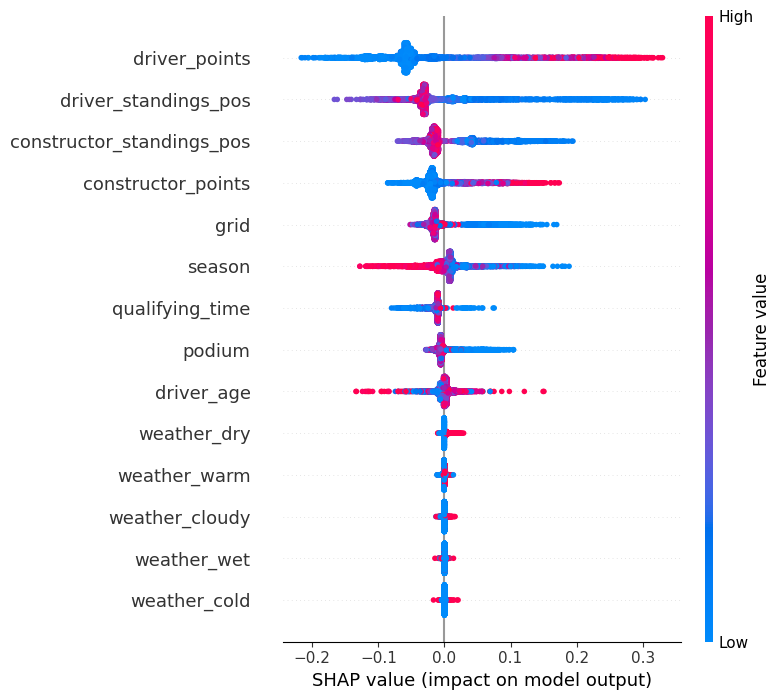

In [34]:
shap.summary_plot(shap_values[1], X_test,feature_names = name)

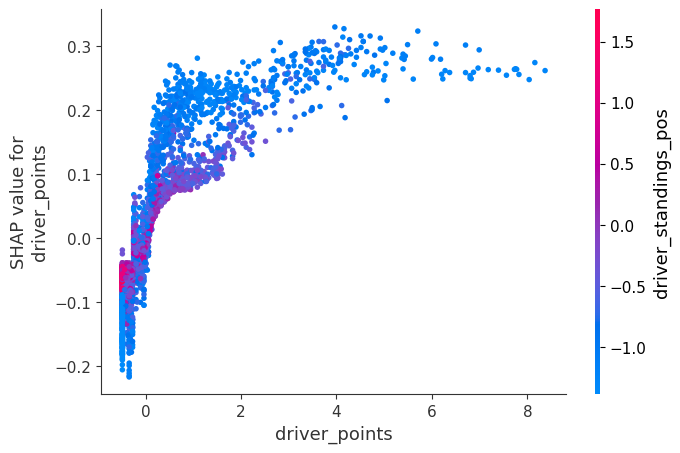

In [38]:
# SHAP Dependence Plots
shap.dependence_plot("driver_points", shap_values[1], X_test,feature_names = name)

# APPLY KernelSHAP

In [39]:
kernel_explainer = shap.KernelExplainer(final.predict_proba,X_train)
shap_values_kernel = kernel_explainer.shap_values(X_test[3,:])
shap.force_plot(kernel_explainer.expected_value[1], shap_values_kernel[1], X_test[3,:],feature_names = name)

Using 4438 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


# DATA PREPROCESS FOR GP-SHAP

In [79]:
#select 10 years data from 2011-2021
data_2021 = data_2021.iloc[10654:]  
data_2021 = data_2021.drop('constructor_points', axis=1, inplace=False)
data_2021

season  weather_warm  weather_cold  weather_dry  weather_wet   
10654    2011             0             0            0            0  \
10655    2011             0             0            0            0   
10656    2011             0             0            0            0   
10657    2011             0             0            0            0   
10658    2011             0             0            0            0   
...       ...           ...           ...          ...          ...   
14789    2021             0             0            0            1   
14790    2021             0             0            0            1   
14791    2021             0             0            0            1   
14792    2021             0             0            0            1   
14793    2021             0             0            0            1   

       weather_cloudy  grid  podium  driver_points  driver_wins   
10654               0     4       6              0            0  \
10655               0     5       4              0            0   
10656               0     6       3              0            0   
10657               0     7      17              0            0   
10658               0     8       7              0            0   
...               ...   ...     ...            ...          ...   
14789               0    13      10              1            0   
14790               0    16       6             10            0   
14791               0    17       8              0            0   
14792               0    18       7              0            0   
14793               0    19      14              0            0   

       driver_standings_pos  constructor_wins  constructor_standings_pos   
10654                     0                 0                          0  \
10655                     0                 0                          0   
10656                     0                 0                          0   
10657                     0                 0                          0   
10658                     0                 0                          0   
...                     ...               ...                        ...   
14789                    15                 0                          8   
14790                    14                 0                          5   
14791                    17                 0                          9   
14792                    19                 0                          9   
14793                    20                 0                         10   

       qualifying_time  driver_age  
10654              1.3          31  
10655              1.5          29  
10656              1.7          26  
10657              1.9          25  
10658              2.1          29  
...                ...         ...  
14789              2.2          41  
14790              2.5          21  
14791              2.5          23  
14792              2.6          26  
14793              3.5          22  

[4140 rows x 15 columns]

In [80]:
X = data_2021.drop('driver_points', axis=1, inplace=False)
y = data_2021['driver_points'].astype(int)
# Split datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (3312, 14)
Shape of X_test:  (828, 14)
Shape of y_train:  (3312,)
Shape of y_test:  (828,)


# Build random forest regressor and apply TreeSHAP

In [62]:
xt = X_train.copy()
xtest = X_test.copy()
yt = y_train.copy()
ytest = y_test.copy()
scaler = StandardScaler()
xt = scaler.fit_transform(xt)
xtest = scaler.fit_transform(xtest)
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(xt, yt)

# Make predictions on the test set
rf_regressor_pred = rf_regressor.predict(xtest)

# Evaluate the model
mean_squared_error(ytest, rf_regressor_pred,squared=False)


19.098486328122878

In [81]:
name_new = X.columns[:]

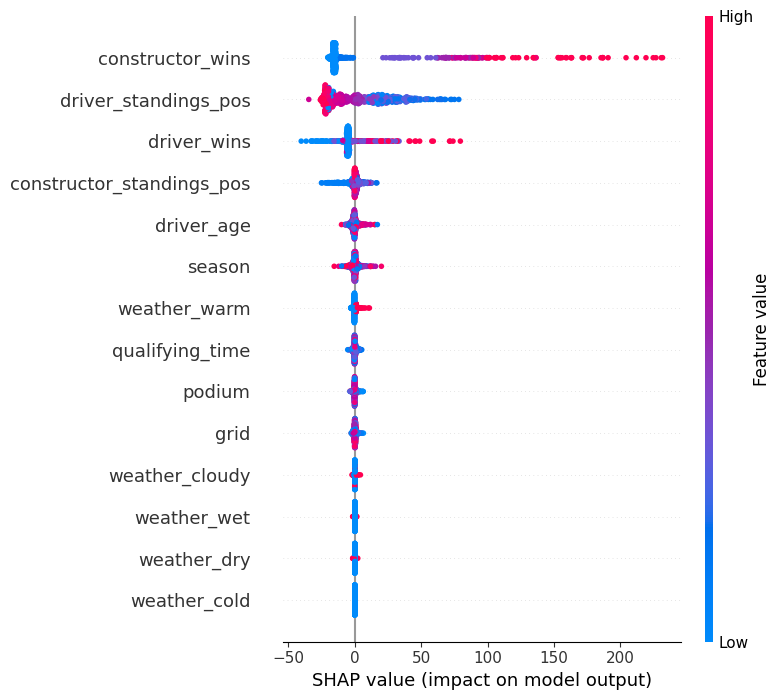

In [64]:

explainer_new = shap.TreeExplainer(rf_regressor)
shap_values_new = explainer_new.shap_values(xtest)
shap.summary_plot(shap_values_new, xtest,feature_names = name_new)

# Fit a Variational GP model

In [82]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [83]:
kernel = RBFKernel
gp_regression = VariationalGPRegression(
    X_train, y_train, kernel=kernel, num_inducing_points=150, batch_size=128)
gp_regression.fit( learning_rate=1e-2,training_iteration=200)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

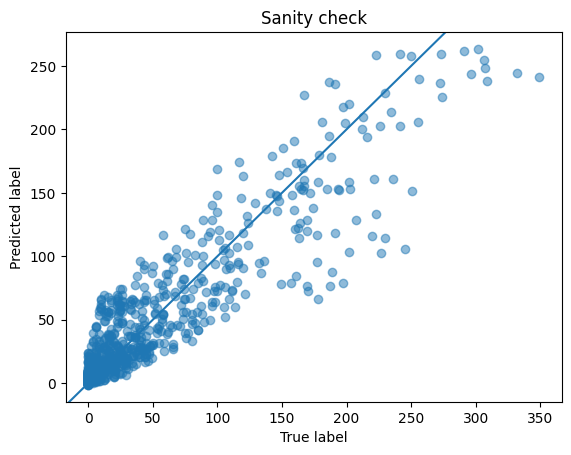

In [84]:
ypred = gp_regression.predict_include_likelihood(X_test).mean.detach()
plt.scatter(y_test, ypred, alpha=.5)
plt.axline((0, 0), slope=1)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Sanity check")
plt.show()

In [85]:
mean_squared_error(y_test, ypred,squared=False)


25.802898

# BayesGPSHAP

In [89]:
# Standardise
scale = y_train.std().numpy()
y_train = (y_train - y_train.mean()) / y_train.std()
bayes_gpshap = BayesGPSHAP(train_X=X_train,
                           scale=scale,
                           model=gp_regression,
                           kernel=kernel(),
                           include_likelihood_noise_for_explanation=False)
bayes_gpshap.fit_bayesgpshap(X_train, num_coalitions=100*X_train.shape[1])

100%|██████████| 1344/1344 [00:44<00:00, 30.11it/s]


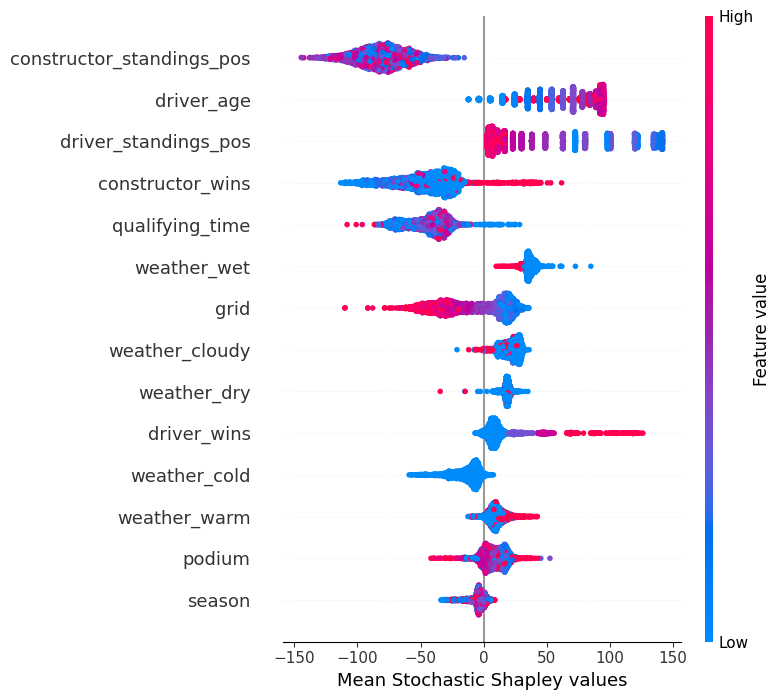

In [90]:
mean_stochastic_shapley_values = bayes_gpshap.return_deterministic_shapley_values()
summary_plot(mean_stochastic_shapley_values, X_train, feature_names=name_new)
plt.xlabel("Mean Stochastic Shapley values")
plt.show()

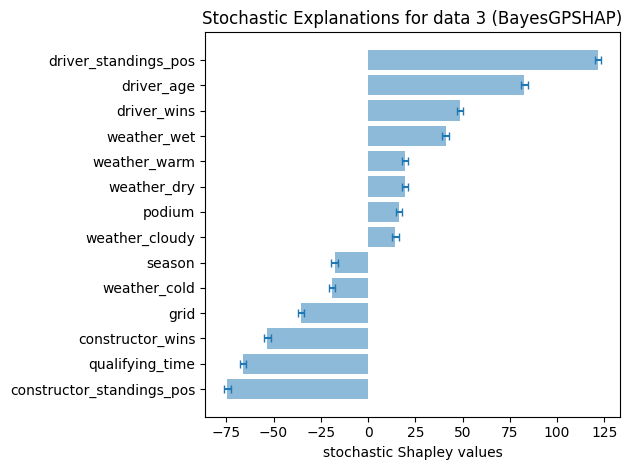

In [94]:
local_explanation_plot(data_id=3,
                       feature_names=name_new,
                       explanation_algorithm=bayes_gpshap,
                       uncertainty_source="BayesGPSHAP",
                       coverage=1
                      )

In [96]:
global_explanation_plot(feature_names=name_new,
                        explanation_algorithm=bayes_gpshap,
                        uncertainty_source="BayesGPSHAP",
                        coverage=1
                       )

# GP-SHAP

In [51]:
from src.explanation_algorithms.GPSHAP import GPSHAP
gpshap = GPSHAP(train_X=X_train,
                           scale=scale,
                           model=gp_regression,
                           kernel=kernel(),
                           include_likelihood_noise_for_explanation=False)
gpshap.fit_gpshap(X_train, num_coalitions=100*X_train.shape[1])

100%|██████████| 1347/1347 [01:01<00:00, 21.92it/s]


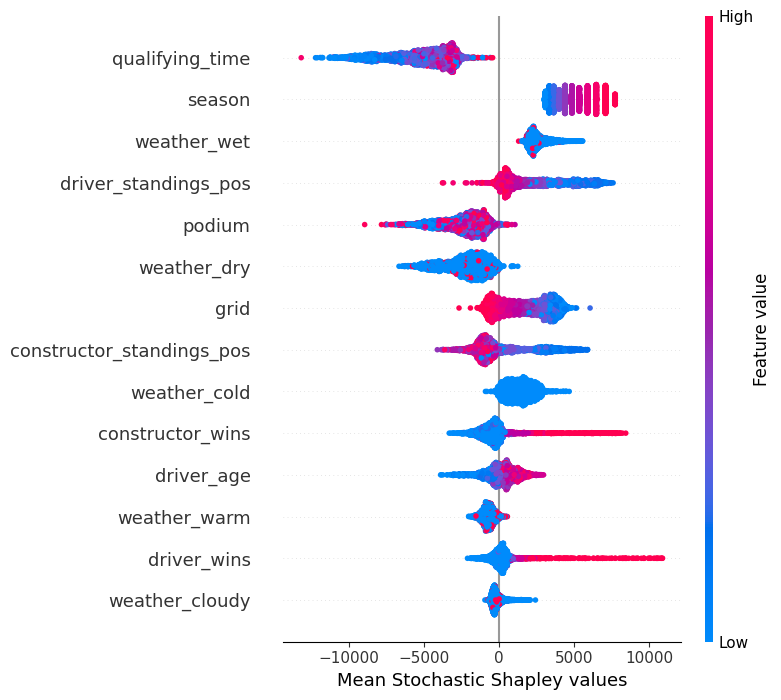

In [52]:
name = X.columns[:]
mean_stochastic_shapley_values = gpshap.return_deterministic_shapley_values()
summary_plot(mean_stochastic_shapley_values, X_train, feature_names=name)
plt.xlabel("Mean Stochastic Shapley values")
plt.show()

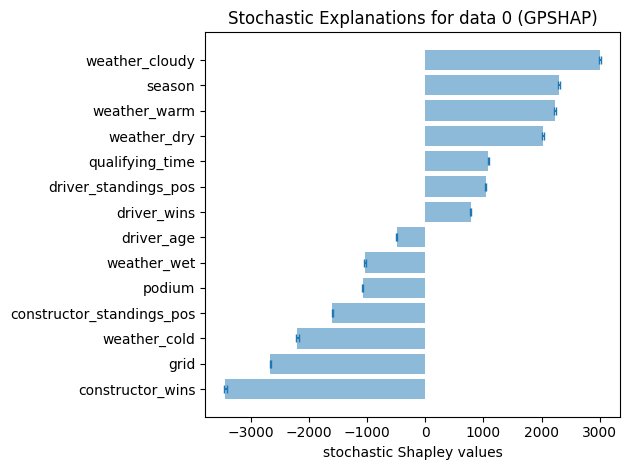

In [53]:
local_explanation_plot(data_id=0,
                       feature_names=name,
                       explanation_algorithm=bayes_gpshap,
                       uncertainty_source="GPSHAP",
                       coverage=1
                      )

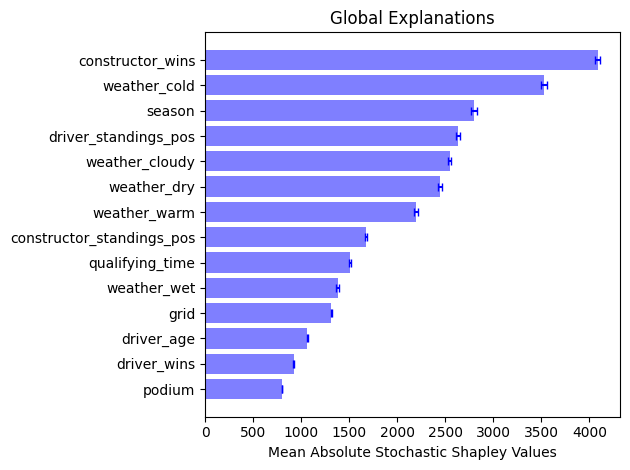

In [54]:
global_explanation_plot(feature_names=name,
                        explanation_algorithm=bayes_gpshap,
                        uncertainty_source="GPSHAP",
                        coverage=1
                       )